# Welcome to Pynq Audio

This notebook shows the basic recording and playback features of the Pynq-Z1.
It uses the audio jack to play back recordings from the built-in microphone, as well as a pre-recorded audio sample. Moreover, visualization with matplotlib and playback with IPython.Audio is shown.

### Basic Functions

In [1]:
# Create new audio object
from pynq.drivers import Audio
pAudio = Audio()

#### Record and Play

In [2]:
# Record a sample
pAudio.record(4)
# Save recorded sample
pAudio.save("Recording_1.pdm")
# Play recorded sample
pAudio.play()

#### Load and Play

In [3]:
# Load a sample
pAudio.load("/home/xilinx/pynq/drivers/tests/pynq_welcome.pdm")
# Play loaded sample
pAudio.play()

### Preprocessing
1. Convert 32bit integer buffer to 16bit
2. Divide 16bit word with 16 1bit samples into 8bit words with 1bit sample each

In [4]:
import time
import sys
import numpy as np
# Convert 32bit input to 16bit input
af_uint16 = pAudio.buffer.copy().astype(np.int16)
# Prepare 8 bit output
af_uint8  = np.zeros(len(af_uint16)*16)

# Divide 16bit words
start = time.time()
for i in range(1, len(af_uint16)):
    # Save high byte (MSBs)
    afbH_uint8 = af_uint16[i].astype(np.uint8)
    # Unpack high byte to single bits
    af_uint8[(i*16):(i*16+8)] = np.unpackbits(afbH_uint8)
    # Save low byte (LSBs)
    afbL_uint8 = (af_uint16[i] >> 8).astype(np.uint8)
    # Unpack low byte to single bits
    af_uint8[(i*16+8):(i*16+16)] = np.unpackbits(afbL_uint8) 
end =  time.time()

print("Time to convert " + str(len(af_uint16)*16) +
      "bit: " + str(end-start) +"s")
print("Size of audio data: " + str(sys.getsizeof(af_uint8)) +
      "Byte (=8x"+ str(len(af_uint16)*16) +"bit)")

del af_uint16

Time to convert 12288000bit: 127.19929003715515s
Size of audio data: 98304048Byte (=8x12288000bit)


### Convert Format to PDM to PCM
* Convert Pulse Density Modulation (PDM) to Pulse Code Modulation (PCM) by decimation
* The sample rate is reduced from 3MHz to 32kHz

In [5]:
import time
import sys
from scipy import signal
start = time.time()
af_dec = signal.decimate(af_uint8, 4)
af_dec = signal.decimate(af_dec, 4)
af_dec = signal.decimate(af_dec, 6)
end = time.time()

print("Time to convert " + str(len(af_uint8)) +
      "bit: " + str(end-start) +"s")
print("Size of audio data: " + 
      str(sys.getsizeof(af_dec)) + "Byte")

del af_uint8

Time to convert 12288000bit: 4.2733354568481445s
Size of audio data: 48Byte


### Plot and Play PCM Data

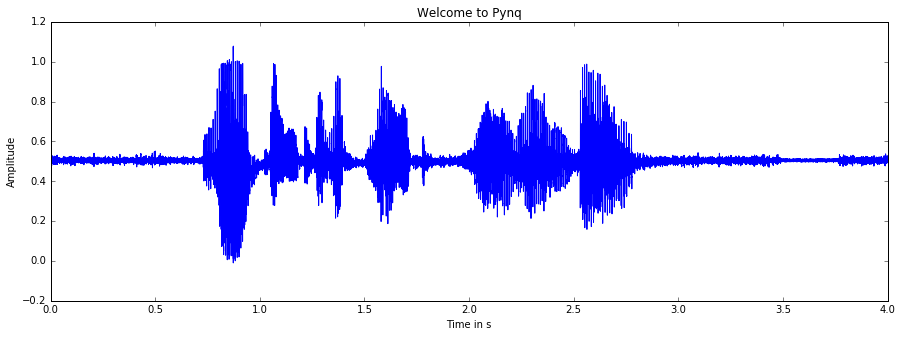

In [6]:
# Amplitude over Time
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

plt.figure(num=None, figsize=(15, 5))
time_axis = np.arange(0,((len(af_dec))/32000),1/32000)
plt.plot(time_axis, af_dec)
plt.title('Welcome to Pynq')
plt.xlabel('Time in s')
plt.ylabel('Amplitude')
plt.show()

In [7]:
# Play PCM in Browser
from IPython.display import Audio as IPAudio
IPAudio(af_dec, rate=32000)